# Reservoir Computer Lyapunov Exponents as $\rho$ changes (paper version)

### ( datasets by $\rho \in A =$ list of values  )

In [1]:
# Import libraries
import math     as math
import numpy    as np
import networkx as nx
import random   as random
import pandas   as pd
import matplotlib.pyplot as plt 
import time     as time

#######################################################################
# E N V I R O N M E N T   S E T   U P
#######################################################################
#---------------------------------------------------------------------#
# To compute elapsed time
#---------------------------------------------------------------------#
start_time = time.time()

## variables description
    D       :(int  ) Input data dimension      
    N       :(int  ) Reservoir dimension (degrees of freedome of the reservoir)       
    rhoSR   :(float) Spectral Radius of A      
    rhoA    :(float) Density of A              
    alpha   :(float) Leak (or leakage) rate in (0,1]                 
    sigma   :(float) Strength of input signal            
    sigmab  :(float) Strength of input bias               
    beta    :(float) Tichonov-Miller regularization parameter
    
    washout :(int)   During training, skipped transitory timesteps in W_out calculation
    spinup  :(int)   Time (n. of timesteps) it takes for a trained RC to converge from its initial condition
                     onto the synchronization manifold to which it is driven by the input data
    normtime:(int)   Range to skip some QR factorisations and speed up the calculations  
            
    r       :(float) Reservoir state
    W_in    :(float) Input matrix              
    A       :(float) Reservoir ajacency matrix 
    b       :(float) bias vector               
    W_out   :(float) Output matrix  
    endtr_r :(float) Last reservoir state in training
    
    R       :(float) Matrix containing r(t) for all t in training dataset
    U       :(float) Matrix containing u(t) for all t in training dataset
    u       :(float) Time series at time t
    v       :(float) Prediction


In [2]:
# ReservoirComputer class declaration
class ReservoirComputer:
    def __init__(self, D, N, rhoSR, rhoA, alpha, sigma, sigmab, beta):
        self.r      = np.zeros(N)
        self.W_in   = get_random_matrix(N, D, xa=-sigma, xb=sigma, nonzero=False)
        self.A      = generate_adjacency_matrix(N, rhoSR, rhoA)
        self.b      = sigmab * np.ones(N)
        self.W_out  = np.zeros((D,N))
        self.endtr_r= np.zeros(N)

    def rc_update_rule(self, y):
        # driven     mode: y = u(t)         ;r(t+1) = F^d_r (r(t),y)
        # autonomous mode: y = W_out . r(t) ;r(t+1) = F^a_r (r(t),y)
        g      = np.dot(self.A, self.r) + np.dot(self.W_in, y) + self.b
        self.r = alpha * np.tanh(g) + (1 - alpha) * self.r

    def update_v(self):
        return np.dot(self.W_out, self.r)

    def train(self, U, washout):
        steps = U.shape[0]
        R     = np.zeros((N, steps))
        for i in range(steps):
            R[:, i] = self.r
            u       = U[i]
            self.rc_update_rule(u)
        self.W_out = linear_regression(R[:,washout:], U[washout:], beta)
        self.endtr_r = self.r # save last training r state

    def spinup(self, U, steps):
        self.r = self.endtr_r # reset reservoir state
        if steps > 0:
            for i in range(steps):
                u = U[i]
                self.rc_update_rule(u) # driven mode
    
    def predict(self, steps):
        prediction = np.zeros((steps, D))
        for i in range(steps):
            v             = self.update_v()
            prediction[i] = v
            self.rc_update_rule(v)
        return prediction

    def rc_lyapunov_exponents(self, steps, dt, normtime):
        save_r = self.r # save r state
        self.r = self.endtr_r # reset r state
        lyap   = np.zeros((N,steps))
        M      = np.eye(N)
        W      = self.A + np.dot(self.W_in,self.W_out)
        j      = -1
        for i in range(steps):
            v     = self.update_v()
            self.rc_update_rule(v) # update r
            #
            g     = np.dot(W, self.r) + self.b
            DF    = alpha * np.dot(np.diag(1 - np.tanh(g)**2),W) \
                    + (1 - alpha) * np.eye(N)
            Mn    = np.dot(DF,M)
            if (i % normtime == 0):
                Q,Rii = np.linalg.qr(Mn)
                j     += 1
                lyap[:,j] = np.log(abs(np.diag(Rii)))
                M = Q
        L = np.sum(lyap,1) / ((j+1)*dt)    
        self.r = save_r # retrieve saved r_state
        return L

    def rc_conditional_lyapunov_exponents(self, U, dt, normtime):
        save_r = self.r # save r state
        self.r = np.zeros(N) # reset r state
        steps  = U.shape[0]
        lyap   = np.zeros((N,steps))
        M      = np.eye(N)
        j      = -1
        for i in range(steps):
            u       = U[i]
            self.rc_update_rule(u) # update r
            #
            g  = np.dot(self.A, self.r) + np.dot(self.W_in, u) + self.b
            DF = alpha * np.dot(np.diag(1 - np.tanh(g)**2),self.A) \
                 + (1 - alpha) * np.eye(N)
            Mn = np.dot(DF,M)
            if (i % normtime == 0):
                Q,Rii = np.linalg.qr(Mn)
                j     += 1
                lyap[:,j] = np.log(abs(np.diag(Rii)))
                M = Q
        CL = np.sum(lyap,1) / ((j+1)*dt)
        self.r = save_r # retrieve saved r_state
        return CL
    
# Helper functions
def generate_adjacency_matrix(N, rhoSR, rhoA):
    # Erdos-Reyni network
    graph = nx.gnp_random_graph(N, rhoA)
    adj   = nx.to_numpy_array(graph)
    # Ensure random_array is of the same shape as the graph adjacency matrix
    random_array = get_random_matrix(N, N, xa =-0.5, xb=0.5, nonzero=True)
    # Multiply graph adjacency matrix with random values
    rescaled     = adj * random_array
    return scale_matrix(rescaled, rhoSR)

def get_random_matrix(nrow, ncol, xa, xb, nonzero):
    B = np.zeros((nrow,ncol))
    for i in range(nrow):
        for j in range(ncol):
            if nonzero:
                while B[i,j] == 0:
                    B[i,j] = xa + (xb - xa) * np.random.rand()
            else:
                B[i,j] = xa + (xb - xa) * np.random.rand()
    return B

def scale_matrix(A, rhoSR):
    eigenvalues = np.linalg.eigvals(A)    # compute eigenvlaues
    sr = np.max(np.absolute(eigenvalues)) # compute spectral radius of A
    if sr > 0:
        A = A * rhoSR / sr                # rescaling matrix if A non zero
    return A

def linear_regression(R, U, beta=.0001): 
    Rt = np.transpose(R)
    inverse_part = np.linalg.inv(np.dot(R, Rt) + beta * np.identity(R.shape[0]))
    return np.dot(np.dot(U.T, Rt), inverse_part)


In [3]:
#######################################################################
# R . C .  H Y P E R P A R A M E T E R   L I S T
#######################################################################
rnd_seed = 167
df_RC_HP = pd.concat([pd.read_csv('climate/df_RC200_seed' + str(rnd_seed) + '_HP_intermittency.csv',delimiter=";",index_col=False)],
                     ignore_index = True)

len_df_RC_HP = len(df_RC_HP)
df_RC_HP = df_RC_HP.astype({'D':'int'})
df_RC_HP = df_RC_HP.astype({'N':'int'})
df_RC_HP = df_RC_HP.astype({'washout':'int'})

rho_list = df_RC_HP.rho_Lorenz

In [4]:
#######################################################################
# M A I N   L O O P 
#######################################################################
dt = 0.01
RC_LE     = np.zeros((len_df_RC_HP, 3)) #3 = Lorenz system dimension
maxCLE    = np.zeros(len_df_RC_HP)      # max CLE list

for s in range(len_df_RC_HP):
    rho_Lorenz  = df_RC_HP.iloc[s].rho_Lorenz
    # read dataset
    str_rho_Lorenz = (f'{rho_Lorenz:07.3f}').replace(".", "_")
    #print("===== ",f'{s:>4d}) : Lorenz rho = {rho_Lorenz:>7.3f}')
    X = np.loadtxt('dataset2/Lorenz_Dataset_'+str(str_rho_Lorenz)+'.csv',delimiter=";")
    n_timesteps = len(X)
    #print(n_timesteps)
    
    # splitting in training and test dataset
    data_length          = len(X) 
    training_percentage  = .8
    training_data_length = round(training_percentage * data_length) 
    #print("data_length          =",data_length)
    #print("training_data_length =",training_data_length)
    training_data = np.array(X[:training_data_length])
    test_data     = np.array(X[training_data_length:])

    # Setting random seed for repeteability
    np.random.seed(rnd_seed)
    random.seed(rnd_seed)    
    
    # set hyperparameter from cartesian product
    D      = round(df_RC_HP.iloc[s].D)
    N      = round(df_RC_HP.iloc[s].N)
    rhoSR  = df_RC_HP.iloc[s].rhoSR
    rhoA   = df_RC_HP.iloc[s].rhoA
    alpha  = df_RC_HP.iloc[s].alpha 
    sigma  = df_RC_HP.iloc[s].sigma
    sigmab = df_RC_HP.iloc[s].sigmab 
    beta   = df_RC_HP.iloc[s].beta
    #
    model   = ReservoirComputer(D, N, rhoSR, rhoA, alpha, sigma, sigmab, beta)
    # training
    washout = round(df_RC_HP.iloc[s].washout) # transitory skipped timesteps
    model.train(training_data, washout)    
    
    # compute RC Lyapunov Exponents
    normtime = 1
    L = model.rc_lyapunov_exponents(len(test_data), dt, normtime)
    RC_LE[s] = L[:D] 
    
    # compute RC Conditional Lyapunov Exponents
    normtime = 1
    CL = model.rc_conditional_lyapunov_exponents(training_data, dt, normtime)
    maxCLE[s] = np.max(CL)   
    
    print(f'{s:>4d}) : Lorenz rho = {rho_Lorenz:>7.3f}',"RC Lyapunov Exponents",RC_LE[s]," max CLE", maxCLE[s])
    
    del model


   0) : Lorenz rho = 166.000 RC Lyapunov Exponents [  0.1379918   -3.55857096 -11.84845135]  max CLE -48.77182463898546
   1) : Lorenz rho = 166.010 RC Lyapunov Exponents [  0.05169078  -0.02741562 -26.23038342]  max CLE -147.02758580104256
   2) : Lorenz rho = 166.020 RC Lyapunov Exponents [-1.14126579e-02 -1.57923681e-01 -2.47430387e+01]  max CLE -86.33516574231841
   3) : Lorenz rho = 166.030 RC Lyapunov Exponents [  2.88916711  -0.29424678 -15.30703522]  max CLE -48.87653297933954
   4) : Lorenz rho = 166.040 RC Lyapunov Exponents [  0.04063748  -1.00643061 -15.76890073]  max CLE -48.77273422397051
   5) : Lorenz rho = 166.050 RC Lyapunov Exponents [ -0.07770614  -0.40507749 -16.63140571]  max CLE -48.77216502532039
   6) : Lorenz rho = 166.060 RC Lyapunov Exponents [ -0.34428002  -1.49210612 -16.838498  ]  max CLE -45.66947446979042
   7) : Lorenz rho = 166.070 RC Lyapunov Exponents [  6.40861324 -56.44245669 -78.77096328]  max CLE -87.70658489854623
   8) : Lorenz rho = 166.080 R

  69) : Lorenz rho = 166.690 RC Lyapunov Exponents [  4.7240589   -0.59648573 -13.70904365]  max CLE -86.62441618997953
  70) : Lorenz rho = 166.700 RC Lyapunov Exponents [  3.84507948  -1.89042591 -13.96474014]  max CLE -87.8123685863446
  71) : Lorenz rho = 166.710 RC Lyapunov Exponents [  7.04530585  -4.2984306  -18.27936218]  max CLE -87.75825509367913
  72) : Lorenz rho = 166.720 RC Lyapunov Exponents [  4.00190157  -1.32969796 -14.32106632]  max CLE -87.79215556668572
  73) : Lorenz rho = 166.730 RC Lyapunov Exponents [  0.72119278  -0.5106466  -13.70445526]  max CLE -87.22147933192372
  74) : Lorenz rho = 166.740 RC Lyapunov Exponents [  4.11413072  -0.58470887 -10.35499625]  max CLE -49.22031882216622
  75) : Lorenz rho = 166.750 RC Lyapunov Exponents [  2.82524555  -1.02265125 -16.59254412]  max CLE -87.24105491170805
  76) : Lorenz rho = 166.760 RC Lyapunov Exponents [  3.99411843  -0.58031178 -11.13792776]  max CLE -49.00130008869643
  77) : Lorenz rho = 166.770 RC Lyapunov 

In [5]:
# Convert numpy array to pandas DataFrame
df_RC_LE = pd.DataFrame(RC_LE)

# Name columns
df_RC_LE.columns =['lambda_1', 'lambda_2', 'lambda_3']

# Using DataFrame.insert() to add a column
df_RC_LE.insert(0, "rho_Lorenz",rho_list, True)

# Using DataFrame.insert() to add a column
df_RC_LE.insert(len(df_RC_LE.columns),"maxCLE",maxCLE, True)

# Save DataFrame to .csv
df_RC_LE.to_csv('climate/df_RC200_seed' + str(rnd_seed) + '_int_LE_PAPER.csv', index=False, header=True, decimal='.', sep=';')


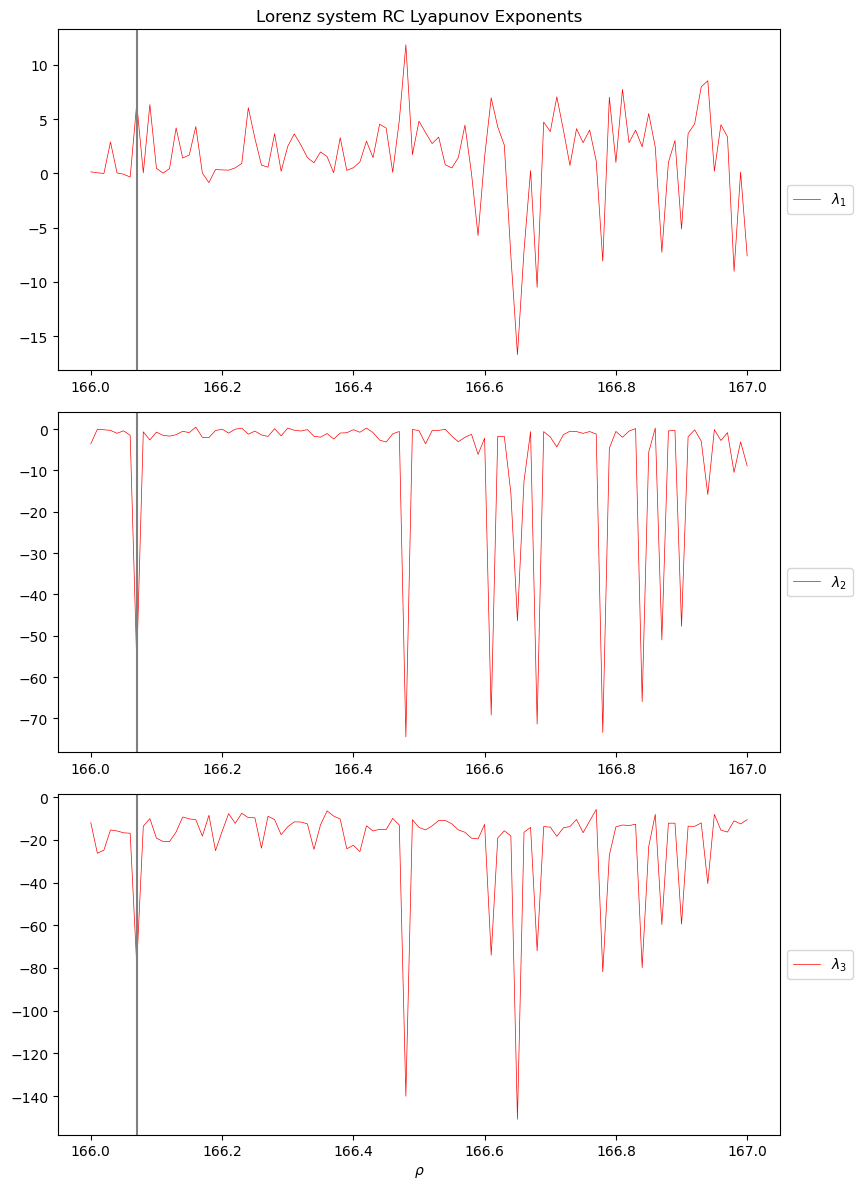

In [6]:
# Plot Lorenz system Lyapunov Exponents
fig, axs = plt.subplots(3, 1, figsize=(8, 12))  

axis_test_label = ["$\lambda_1$"     ,"$\lambda_2$"     ,"$\lambda_3$"     ]
axs[0].set_title("Lorenz system RC Lyapunov Exponents")

for i in range(D):
    axs[i].plot(rho_list, RC_LE[:,i] , label= axis_test_label[i], color='red' , lw = 0.5)
    #
    # Shrink current axis by 20%
    box = axs[i].get_position()
    axs[i].set_position([box.x0, box.y0, box.width * 0.8, box.height])
    # Put a legend to the right of the current axis
    axs[i].legend(loc='center left', bbox_to_anchor=(1, 0.5))

    axs[i].axvline(x = 166.07   , color = 'grey')
    
axs[2].set_xlabel("$\\rho$") #\\rho need to prevent parsing error!!!
fig.tight_layout()

plt.show()

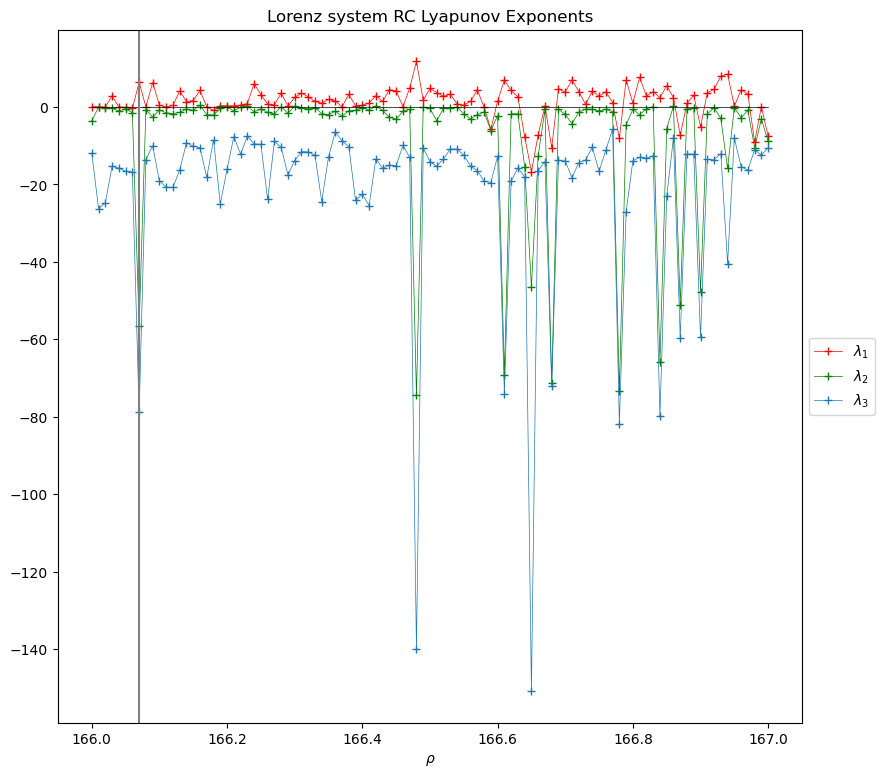

In [7]:
# Plot Lorenz system Lyapunov Exponents
fig = plt.figure(figsize = (12, 9)) 
ax  = fig.add_subplot(1, 1, 1)

axis_test_label = ["$\lambda_1$"     ,"$\lambda_2$"     ,"$\lambda_3$"     ]
ax.set_title("Lorenz system RC Lyapunov Exponents")

ax.plot(rho_list, RC_LE[:,0] , label= axis_test_label[0], color='red'  , marker='+',lw = 0.5)
ax.plot(rho_list, RC_LE[:,1] , label= axis_test_label[1], color='green', marker='+',lw = 0.5)
ax.plot(rho_list, RC_LE[:,2] , label= axis_test_label[2], color='C0'   , marker='+',lw = 0.5)
ax.plot(rho_list, 0*RC_LE[:,0], color='black', lw = 0.5)
#
ax.axvline(x = 166.07   , color = 'grey')
#
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_xlabel("$\\rho$") #\\rho need to prevent parsing error!!!

plt.show()

In [8]:
#---------------------------------------------------------------------#---------------------------------------------------------------------#
# Elapsed time
#---------------------------------------------------------------------#
print(f'\nElapsed time {time.time() - start_time:6.2e} s')


Elapsed time 8.93e+03 s
